In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from pathlib import Path
from ds100_utils import fetch_and_cache
from datetime import datetime
from IPython.display import display

import yaml

plt.rcParams['figure.figsize'] = (6, 6)
plt.rcParams['figure.dpi'] = 100
sns.set()

# Data

In [3]:
# From Lecture 4: current members of congress
base_url = 'https://github.com/unitedstates/congress-legislators/raw/master/'
current_path = 'legislators-current.yaml'
f = fetch_and_cache(base_url + current_path, current_path)
current_data = yaml.load(open(f))

def birthdays(data):
    return pd.DataFrame(
        columns=['leg_id', 'first', 'last', 'gender', 'terms', 'birthday'],
        data=[[x['id']['bioguide'], 
               x['name']['first'],
               x['name']['last'],
               x['bio']['gender'],
               len(x['terms']),
               pd.to_datetime(x['bio'].get('birthday'), yearfirst=True)
              ] for x in data])

current_legs = birthdays(current_data)
current_legs.head(3)

Using cached version that was downloaded (UTC): Tue Feb 26 07:21:32 2019


,leg_id,first,last,gender,terms,birthday
0,B000944,Sherrod,Brown,M,10,1952-11-09
1,C000127,Maria,Cantwell,F,5,1958-10-13
2,C000141,Benjamin,Cardin,M,13,1943-10-05


In [4]:
# Past members of congress
past_path = 'legislators-historical.yaml'
f = fetch_and_cache(base_url + past_path, past_path)
past_data = yaml.load(open(f))

past_legs = birthdays(past_data)
past_legs.head(3)

Using cached version that was downloaded (UTC): Tue Feb 26 07:26:47 2019


,leg_id,first,last,gender,terms,birthday
0,B000226,Richard,Bassett,M,1,1745-04-02
1,B000546,Theodorick,Bland,M,1,1742-03-21
2,B001086,Aedanus,Burke,M,1,1743-06-16


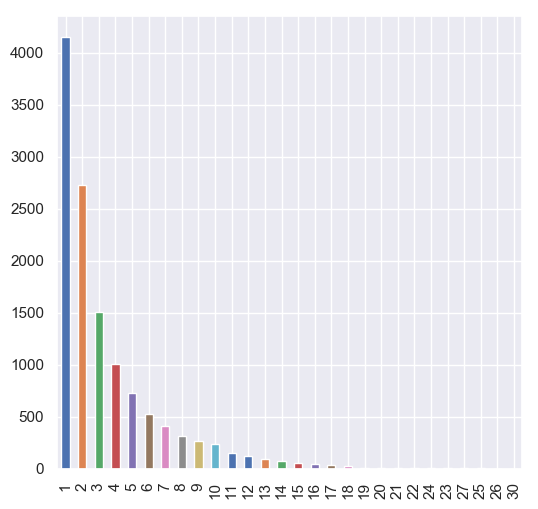

In [5]:
legs = pd.concat([past_legs, current_legs]).reset_index(drop=True)
assert legs.shape[0] == len(legs['leg_id'].unique()) # No repeats
legs['terms'].value_counts().plot(kind='bar');

# Study Design

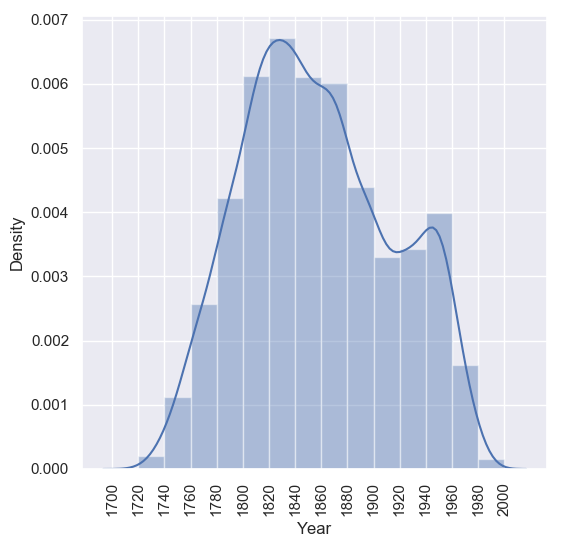

In [6]:
bins = np.linspace(1700, 2000, 16)
sns.distplot(legs['birthday'].dropna().dt.year, bins=bins)
plt.xlabel('Year');
plt.xticks(bins, rotation=90)
plt.ylabel('Density');

## Question
According to the histogram, about what proportion of all members of congress were born between 1840 and 1880?

In [7]:
0.006 * (40)

0.24

## Question
How do you compute the exact proportion using Pandas?

In [8]:
# Solution 1
bday = legs['birthday']
sum((bday.dt.year >= 1840) & (bday.dt.year < 1880)) / len(bday)

0.23167905378406456

In [9]:
# Solution 2
sum((bday.dt.year >= 1840) & (bday.dt.year < 1880)) / len(bday.dropna())

0.24239130434782608

In [10]:
bday.isnull().value_counts()

False    11960
True       553
Name: birthday, dtype: int64

In [11]:
sum(bday.isnull()) / len(bday)

0.04419403820027172

# Question
How do you think the missing birthdays bias the birthyear distribution?

```
(a) Low bins have too little density
(b) High bins have too little density
(c) All bins have too little density
(d) Impossible to tell
```

Could inspecting the data further help answer this question?

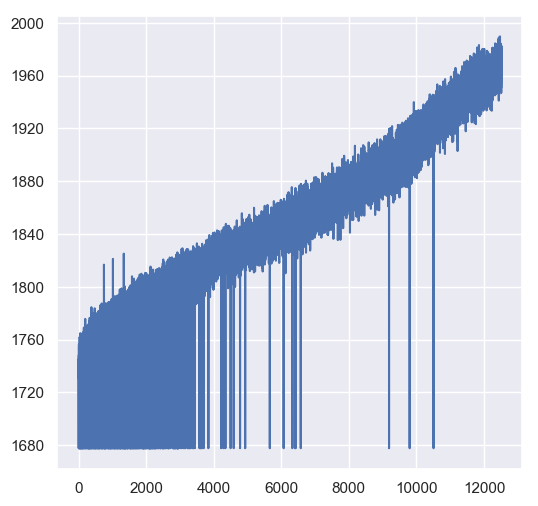

In [12]:
legs['birthday'].plot();

## Question

How would you better visualize the rate of missing values?

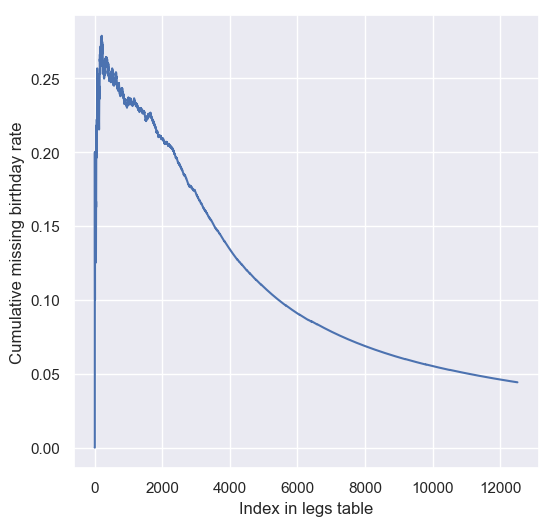

In [13]:
plt.plot(np.cumsum(bday.isnull())/np.arange(len(bday)));
plt.xlabel('Index in legs table')
plt.ylabel('Cumulative missing birthday rate');

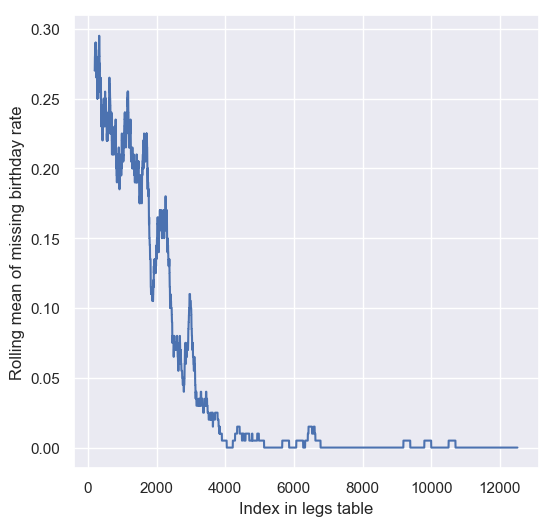

In [14]:
bday.isnull().rolling(200).mean().plot();
plt.xlabel('Index in legs table')
plt.ylabel('Rolling mean of missing birthday rate');

# Data Cleaning

In [15]:
past_data[0]

{'id': {'bioguide': 'B000226',
  'govtrack': 401222,
  'icpsr': 507,
  'wikipedia': 'Richard Bassett (politician)',
  'wikidata': 'Q518823',
  'google_entity_id': 'kg:/m/02pz46'},
 'name': {'first': 'Richard', 'last': 'Bassett'},
 'bio': {'birthday': '1745-04-02', 'gender': 'M'},
 'terms': [{'type': 'sen',
   'start': '1789-03-04',
   'end': '1793-03-03',
   'state': 'DE',
   'class': 2,
   'party': 'Anti-Administration'}]}

## Question

What will be the granularity of a table that includes term information?

In [16]:
past_data[10000]

{'id': {'bioguide': 'H000717',
  'govtrack': 405569,
  'icpsr': 4518,
  'wikipedia': 'Elmer J. Holland',
  'house_history': 15170,
  'wikidata': 'Q5366586',
  'google_entity_id': 'kg:/m/0dn46g'},
 'name': {'first': 'Elmer', 'middle': 'Joseph', 'last': 'Holland'},
 'bio': {'birthday': '1894-01-08', 'gender': 'M'},
 'terms': [{'type': 'rep',
   'start': '1941-01-03',
   'end': '1943-01-03',
   'state': 'PA',
   'district': 33,
   'party': 'Democrat'},
  {'type': 'rep',
   'start': '1955-01-05',
   'end': '1957-01-03',
   'state': 'PA',
   'district': 30,
   'party': 'Democrat'},
  {'type': 'rep',
   'start': '1957-01-03',
   'end': '1959-01-03',
   'state': 'PA',
   'district': 30,
   'party': 'Democrat'},
  {'type': 'rep',
   'start': '1959-01-07',
   'end': '1961-01-03',
   'state': 'PA',
   'district': 30,
   'party': 'Democrat'},
  {'type': 'rep',
   'start': '1961-01-03',
   'end': '1963-01-03',
   'state': 'PA',
   'district': 30,
   'party': 'Democrat'},
  {'type': 'rep',
   'star

In [17]:
columns=['leg_id', 'term', 'type', 'start', 'end', 'state', 'party']
data = []
for x in past_data + current_data:
    for i, t in enumerate(x['terms']):
        data.append([
            x['id']['bioguide'], 
            i + 1,
            t['type'],
            pd.to_datetime(t['start'], yearfirst=True),
            pd.to_datetime(t['end'], yearfirst=True),
            t['state'],
            t.get('party'),
        ])
        
terms = pd.DataFrame(columns=columns, data=data)
terms.head()

,leg_id,term,type,start,end,state,party
0,B000226,1,sen,1789-03-04,1793-03-03,DE,Anti-Administration
1,B000546,1,rep,1789-03-04,1791-03-03,VA,None
2,B001086,1,rep,1789-03-04,1791-03-03,SC,None
3,C000187,1,rep,1789-03-04,1791-03-03,MD,None
4,C000538,1,rep,1789-03-04,1791-03-03,PA,None


In [18]:
terms.shape

(44000, 7)

In [19]:
terms.groupby(['leg_id', 'start']).size().sort_values(ascending=False).head(15)

leg_id   start     
A000083  1881-12-05    2
S001073  1801-12-07    2
V000074  1811-11-04    2
M000034  1815-12-04    2
W000238  1827-12-03    2
L000393  1893-08-07    2
C000150  1861-07-04    2
A000130  1889-12-02    2
G000414  1857-12-07    2
B000769  1905-12-04    2
R000063  1851-12-01    2
B000434  1813-05-24    2
G000071  1955-01-05    1
         1953-01-03    1
         1951-01-03    1
dtype: int64

In [20]:
terms['party'].value_counts()

Democrat                      20447
Republican                    18868
Whig                           1203
Jackson                         880
Federalist                      819
Adams                           256
Ind. Republican-Democrat        128
American                         84
Anti Masonic                     77
Unionist                         77
Populist                         68
Anti Jacksonian                  56
Independent                      45
Progressive                      43
Jacksonian                       39
Ind. Democrat                    39
Unconditional Unionist           35
Nullifier                        34
Democratic Republican            34
Farmer-Labor                     31
National Greenbacker             28
Ind. Republican                  22
Pro-Administration               21
Anti-Jacksonian                  21
Free Soil                        21
Popular Democrat                 16
Anti-Administration              15
Liberal Republican          

In [21]:
terms['party'].value_counts().head(8)

Democrat                    20447
Republican                  18868
Whig                         1203
Jackson                       880
Federalist                    819
Adams                         256
Ind. Republican-Democrat      128
American                       84
Name: party, dtype: int64

## Question

How many terms were under the American party and smaller parties?

In [22]:
sum(terms['party'].value_counts().loc['American':])

940

In [23]:
sum(terms['party'].value_counts().iloc[7:])

940

In [24]:
terms['party'].isnull().value_counts()

False    43541
True       459
Name: party, dtype: int64

# Question

What proportion of all members of congress ever changed parties?

In [25]:
parties = (terms['party']
           .groupby(terms['leg_id'])
           .agg(lambda s: len(set(s)))) # Also .nunique()

parties.value_counts()

1    11657
2      693
3      146
4       14
5        2
6        1
Name: party, dtype: int64

In [26]:
sum(parties > 1) / len(parties)

0.06840885479101734

In [27]:
counts = terms.groupby('leg_id').nunique()
counts['party'].value_counts()

1    11588
2      642
0      167
3      101
4       12
5        2
6        1
Name: party, dtype: int64

In [28]:
counts['state'].value_counts()

1    12453
2       58
3        2
Name: state, dtype: int64

# Visualization

In [29]:
a = terms.groupby('start')
starts = a.nunique()
starts.head(10)

,leg_id,term,type,start,end,state,party
start,,,,,,,
1789-03-04,90,1,2,1,4,13,6
1790-01-01,5,1,1,1,4,3,3
1791-03-04,1,1,1,1,1,1,0
1791-10-24,80,2,2,1,5,15,6
1792-01-01,2,1,1,1,1,2,1
1792-06-18,1,1,1,1,1,1,1
1793-01-10,1,1,1,1,1,1,1
1793-12-02,120,3,2,1,5,16,6
1794-01-01,3,1,1,1,2,2,2


## Question

What visualization will help determine which term starts follow from national elections?

```
(a) A histogram of start values in terms
(b) A line plot of start values in terms
(c) A histogram of leg_id values in starts
(d) A line plot of leg_id values in starts
```

How would you use this visualization to focus future analysis on the composition of congress after each national election?

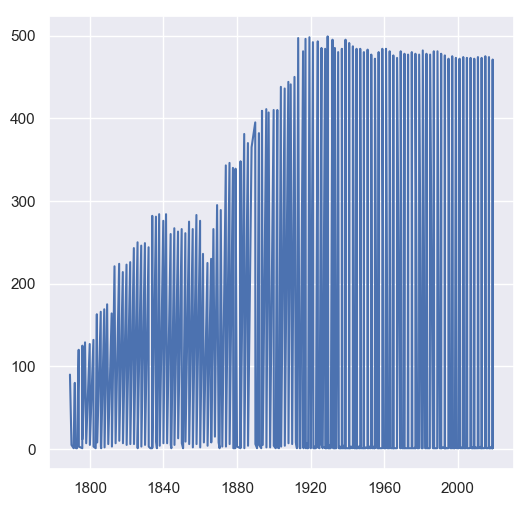

In [30]:
plt.plot(starts['leg_id']);

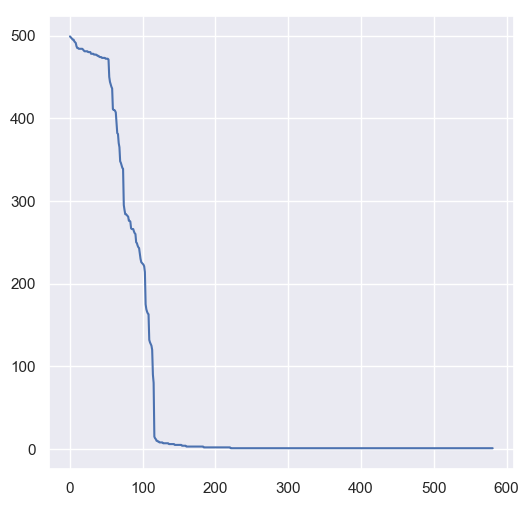

In [31]:
plt.plot(starts['leg_id'].sort_values(ascending=False).values);

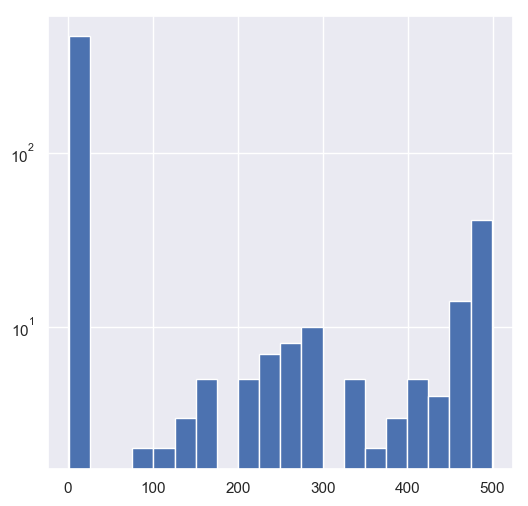

In [32]:
plt.hist(starts['leg_id'], bins=20, log=True);

In [33]:
sum((starts['leg_id'] > 15) & (starts['leg_id'] < 80))

0

In [34]:
starts[starts['leg_id'] > 15].index

DatetimeIndex(['1789-03-04', '1791-10-24', '1793-12-02', '1795-12-07',
               '1797-05-15', '1799-12-02', '1801-12-07', '1803-10-17',
               '1805-12-02', '1807-10-26',
               ...
               '2001-01-03', '2003-01-07', '2005-01-04', '2007-01-04',
               '2009-01-06', '2011-01-05', '2013-01-03', '2015-01-06',
               '2017-01-03', '2019-01-03'],
              dtype='datetime64[ns]', name='start', length=116, freq=None)

In [35]:
biannual = pd.to_datetime([f'01-25-{n}' for n in range(1941, 2020, 2)])
biannual

DatetimeIndex(['1941-01-25', '1943-01-25', '1945-01-25', '1947-01-25',
               '1949-01-25', '1951-01-25', '1953-01-25', '1955-01-25',
               '1957-01-25', '1959-01-25', '1961-01-25', '1963-01-25',
               '1965-01-25', '1967-01-25', '1969-01-25', '1971-01-25',
               '1973-01-25', '1975-01-25', '1977-01-25', '1979-01-25',
               '1981-01-25', '1983-01-25', '1985-01-25', '1987-01-25',
               '1989-01-25', '1991-01-25', '1993-01-25', '1995-01-25',
               '1997-01-25', '1999-01-25', '2001-01-25', '2003-01-25',
               '2005-01-25', '2007-01-25', '2009-01-25', '2011-01-25',
               '2013-01-25', '2015-01-25', '2017-01-25', '2019-01-25'],
              dtype='datetime64[ns]', freq=None)

## Question

What values/distributions should be visualized to determine whether the members of congress are older now than they used to be?

## Question

Using SQL, build a table of (term, election_date) pairs that contains the age of the person serving each term.

In [36]:
import sqlite3
conn = sqlite3.connect(':memory:')
terms.to_sql('terms', conn)
legs.to_sql('legs', conn)
pd.DataFrame({'election': biannual}).to_sql('elections', conn)
for exp in conn.execute('SELECT sql FROM sqlite_master'):
    print(exp[0])

CREATE TABLE "terms" (
"index" INTEGER,
  "leg_id" TEXT,
  "term" INTEGER,
  "type" TEXT,
  "start" TIMESTAMP,
  "end" TIMESTAMP,
  "state" TEXT,
  "party" TEXT
)
CREATE INDEX "ix_terms_index"ON "terms" ("index")
CREATE TABLE "legs" (
"index" INTEGER,
  "leg_id" TEXT,
  "first" TEXT,
  "last" TEXT,
  "gender" TEXT,
  "terms" INTEGER,
  "birthday" TIMESTAMP
)
CREATE INDEX "ix_legs_index"ON "legs" ("index")
CREATE TABLE "elections" (
"index" INTEGER,
  "election" TIMESTAMP
)
CREATE INDEX "ix_elections_index"ON "elections" ("index")


In [37]:
query = """
    SELECT election, state, party, 
           gender, first, last, 
           birthday, election - birthday AS age,
           CASE type WHEN "sen" THEN "Senate"
                     WHEN "rep" THEN "House" END AS chamber
    FROM terms, legs, elections 
    WHERE start <= election AND election < end AND 
          terms.leg_id=legs.leg_id
    """

df = pd.read_sql(query, conn)
df.head()

,election,state,party,gender,first,last,birthday,age,chamber
0,1941-01-25 00:00:00,MI,Democrat,M,Prentiss,Brown,1889-06-18 00:00:00,52.0,Senate
1,1941-01-25 00:00:00,SD,Democrat,M,William,Bulow,1869-01-13 00:00:00,72.0,Senate
2,1941-01-25 00:00:00,SC,Democrat,M,James,Byrnes,1882-05-02 00:00:00,59.0,Senate
3,1941-01-25 00:00:00,MS,Democrat,M,Byron,Harrison,1881-08-29 00:00:00,60.0,Senate
4,1941-01-25 00:00:00,IA,Democrat,M,Clyde,Herring,1879-05-03 00:00:00,62.0,Senate


In [38]:
df['election'] = pd.to_datetime(df['election'], yearfirst=True)
df['birthday'] = pd.to_datetime(df['birthday'], yearfirst=True)
df.head()

,election,state,party,gender,first,last,birthday,age,chamber
0,1941-01-25,MI,Democrat,M,Prentiss,Brown,1889-06-18,52.0,Senate
1,1941-01-25,SD,Democrat,M,William,Bulow,1869-01-13,72.0,Senate
2,1941-01-25,SC,Democrat,M,James,Byrnes,1882-05-02,59.0,Senate
3,1941-01-25,MS,Democrat,M,Byron,Harrison,1881-08-29,60.0,Senate
4,1941-01-25,IA,Democrat,M,Clyde,Herring,1879-05-03,62.0,Senate


In [39]:
df.shape

(21757, 9)

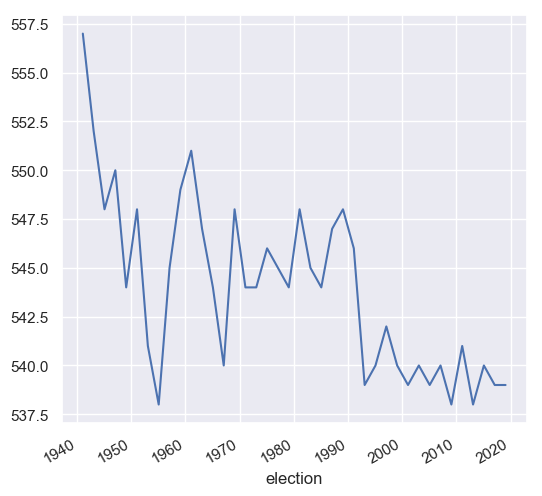

In [40]:
df.groupby('election').size().plot();

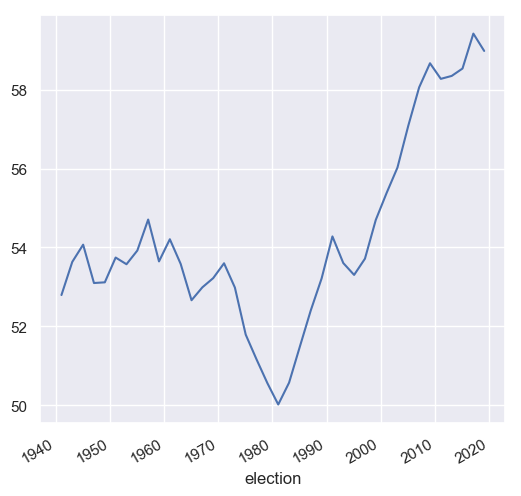

In [41]:
df.groupby('election').mean()['age'].plot();

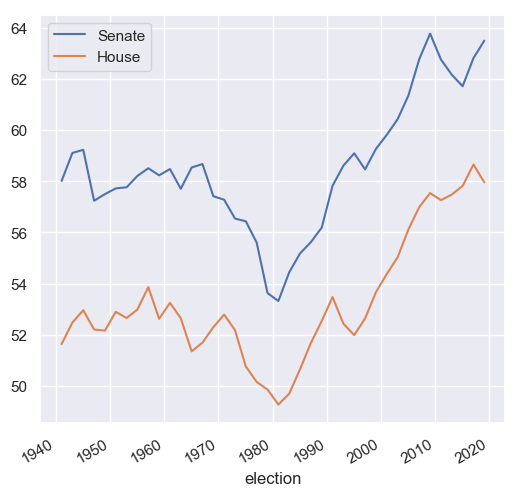

In [42]:
for chamber in ['Senate', 'House']:
    df[df['chamber']==chamber].groupby('election').mean()['age'].plot(label=chamber);
plt.legend();

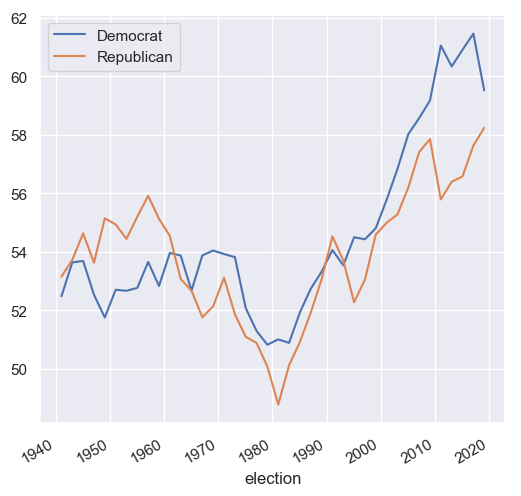

In [43]:
for party in ['Democrat', 'Republican']:
    df[df['party']==party].groupby('election').mean()['age'].plot(label=party);
plt.legend();

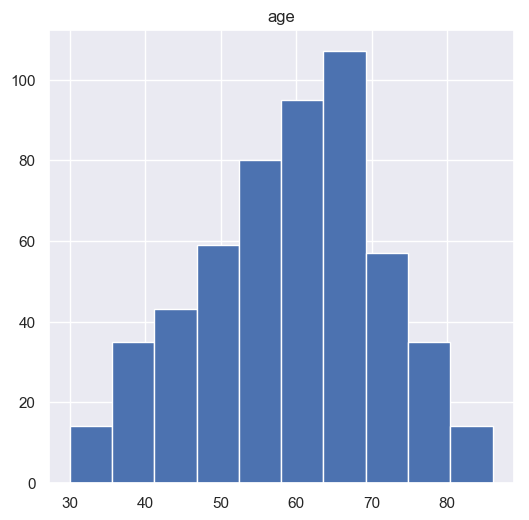

In [44]:
df[df['election'].dt.year == 2019].hist('age');

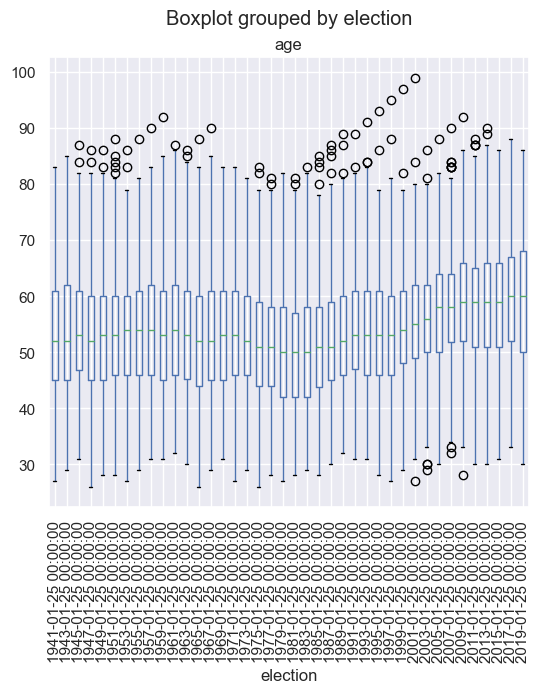

In [45]:
df.boxplot('age', 'election', rot=90);

## Question

What does the boxplot reveal that was not obvious from the line plot?

Why does this boxplot have diagonal lines of outliers?